<a href="https://colab.research.google.com/github/spandandey21/hello-world/blob/master/Working_fine_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helpful Functions

In [0]:
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd



    
    

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

## Reading Data

In [0]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping


#from google.colab import files
#uploaded = files.upload()
#df1 = pd.read_csv(io.BytesIO(uploaded['Bangla.csv']))
#df2 = pd.read_csv(io.BytesIO(uploaded['English.csv']))
df1=pd.read_csv("Bangla.csv",na_values=['NA','?'])
df2=pd.read_csv("English.csv",na_values=['NA','?'])

#path = "./data/"
    
#filename1 = os.path.join(path,"s1_c.csv")    
#df1 = pd.read_csv(filename1,na_values=['NA','?'])

#filename2 = os.path.join(path,"s2_c.csv")    
#df2 = pd.read_csv(filename2,na_values=['NA','?'])
frames = [df1, df2]
df = pd.concat(frames, keys=['x', 'y'])

# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)


signal = encode_text_index(df,"signal")
x,y = to_xy(df,"signal")

# Keep a 20% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(
    x, y, test_size=0.2) 


# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x_main, y_main, test_size=0.2, random_state=42)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
df1


,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,signal
0,21.679432,1.504479,-9.957744,6.751679,-6.002940,6.807267,-2.029461,13.809511,9.941748,16.909974,5.348232,0.328209,-8.071477,Bangla
1,22.317693,0.287187,-9.879319,7.738654,-6.140203,7.362541,1.890642,17.393305,16.327391,24.916220,15.661765,2.796100,-14.148841,Bangla
2,22.532872,0.758670,-9.888254,8.185273,-5.043289,8.578440,0.975402,15.029722,13.541073,22.887587,13.270690,3.681292,-12.629527,Bangla
3,22.743923,0.901887,-10.181835,7.861210,-5.523244,9.158475,1.240076,14.818314,9.953380,18.919487,9.761265,-0.033846,-13.066207,Bangla
4,22.805387,1.342649,-9.418506,6.871316,-6.178653,7.622323,2.249028,15.520012,9.847824,19.792311,14.239703,-0.698241,-14.182394,Bangla
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4314,22.546971,2.160500,-9.836560,6.929788,-7.864586,6.985059,-3.295849,3.538401,-8.700346,-3.784008,-8.629158,0.844142,0.355255,Bangla
4315,22.151003,2.511947,-9.439595,7.880640,-7.551974,6.231159,-3.677819,6.861044,-6.599741,-2.335452,-5.473506,-0.161824,-0.121897,Bangla
4316,22.018945,2.603444,-9.315688,9.468042,-5.692170,7.370515,-6.362984,8.010874,-6.433576,-5.195874,-11.393312,3.105475,-1.804967,Bangla
4317,22.285112,2.764023,-9.123929,9.345041,-5.697530,6.962715,-6.329002,8.447740,-2.695686,-0.722245,-9.054281,3.480604,-1.945926,Bangla


In [0]:
df2

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,signal
0,21.490396,2.978830,-9.115631,6.297544,-7.719752,5.801105,-4.460626,2.087003,-10.115062,-2.318203,-3.981129,3.263657,2.224177,English
1,21.997601,2.553598,-9.380871,5.571617,-9.227934,4.549457,-5.865238,0.767156,-14.318335,-7.634783,-7.080810,2.778006,4.924817,English
2,22.152114,1.920662,-9.998520,5.875681,-9.426330,5.038416,-8.144152,-1.563014,-15.456012,-8.583584,-12.571506,3.003632,5.229453,English
3,22.231372,1.591383,-9.629861,8.690586,-9.597754,4.532085,-10.326629,-4.147025,-16.292237,-10.662058,-14.141704,2.965400,7.031065,English
4,22.128014,1.417125,-9.122610,10.117081,-9.859915,3.789268,-10.312080,-3.647807,-18.229951,-14.416322,-12.587735,1.619900,7.867142,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4314,21.141941,2.332814,-10.227407,6.396827,-7.470780,6.609615,-4.744974,4.950138,-7.924801,0.373726,-4.261428,-0.037490,-2.699396,English
4315,21.114221,2.150977,-10.359617,6.411745,-8.707929,4.700196,-6.440248,3.727142,-9.920915,-1.984913,-4.754298,-2.281805,-4.442828,English
4316,21.119989,2.356106,-10.193827,5.075513,-10.430639,1.562312,-8.059811,1.984105,-8.175989,-3.055492,-6.811266,-1.562141,-4.758216,English
4317,21.115034,2.394855,-10.126092,4.857200,-10.721030,1.150927,-7.636263,3.057093,-5.314412,-2.107432,-6.845570,1.746267,-1.443737,English


In [0]:
df

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,signal
0,20.025171,2.628488,-9.712582,6.756245,-7.212026,6.031144,-7.614029,3.500561,-8.584224,-0.925271,-6.725987,3.249787,2.495667,1
1,22.170082,2.294754,-9.896802,6.312880,-5.552039,8.403295,-1.735058,11.526407,2.262370,10.241741,2.650227,2.162987,-8.389478,1
2,23.880435,3.311172,-9.004375,6.216714,-6.070072,8.579436,-3.409355,1.234124,-3.786311,6.059224,-5.737319,4.259069,-4.287306,0
3,20.996837,2.349743,-9.550572,8.061570,-7.234631,7.954300,-0.959845,9.063077,3.086608,9.932547,0.184395,-0.263473,-7.946416,1
4,22.703805,3.221639,-8.965639,7.064991,-7.203170,5.081689,-6.590844,2.997971,-8.144256,-1.321064,-4.062354,5.386270,3.108930,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8633,20.433772,1.884846,-9.669015,7.002919,-7.296481,7.138320,-0.821354,11.813936,9.022390,15.913513,4.846807,1.259331,-10.713008,1
8634,21.171429,1.713106,-10.987889,6.888440,-8.662182,5.311437,-7.729338,1.001342,-8.790685,1.490530,-4.379940,2.796619,-0.409854,1
8635,22.233571,2.322799,-10.164128,7.179682,-5.342095,8.903784,-3.445533,8.630638,-3.083479,3.568582,-4.022373,3.520629,-4.019293,1
8636,22.974206,1.689067,-10.458950,7.341450,-9.363823,3.838920,-8.281853,0.903620,-7.823409,-0.745210,-5.294785,2.808350,-0.738296,0


In [0]:
#scaler = preprocessing.StandardScaler().fit(x_train)


In [0]:
#train = scaler.transform(x_train)  

In [0]:
#x_test = scaler.transform(x_test)

In [0]:
#x_holdout= scaler.transform(x_holdout)

In [0]:
x.shape

(8638, 13)

In [0]:
x_holdout.shape

(1728, 13)

In [0]:
x_test.shape

(1382, 13)

In [0]:
x_train.shape

(5528, 13)

## Define CNN

In [0]:
import keras
from keras.models import Sequential
from keras import layers
from keras import backend as K
from keras import optimizers
import tensorflow as tf
import time
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time



In [0]:
batch_size = 1024
num_classes = 2
epochs = 10
start_time = time.time()

# Cross-validate
kf = KFold(5)
    
oos_y = []
oos_pred = []
fold = 0
plot_loss = np.empty ((0,epochs))
plot_acc = np.empty ((0,epochs))

for train, test in kf.split(x_main):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
    
    X_train = np.expand_dims(x_train, axis=2) # reshape (569, 30) to (569, 30, 1) 

   

    model = Sequential()
    model.add(layers.Conv1D(40,2, activation='relu', input_shape=(13,1)))
    model.add(layers.Conv1D(40,2, activation='relu'))
    model.add(layers.MaxPooling1D(strides=2, pool_size=2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv1D(60,2, activation='relu'))
    model.add(layers.Conv1D(60,2, activation='relu'))
    

    model.add(layers.Flatten())
    model.add(layers.Dense(30))
    model.add(layers.Activation('relu'))
    #keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10))
    model.add(layers.Activation('relu'))
    #keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(y_train.shape[1],activation='sigmoid')) # Output

    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss',
                            min_delta=1e-3,
                            patience=5,
                            verbose=0,
                            mode='auto')
    checkpointer = ModelCheckpoint(filepath="best_weights.h5",
                                   verbose=2,
                                   save_best_only=True) # save best model

    

    X_test = np.expand_dims(x_test, axis=2)
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        #callbacks=[monitor],
                        verbose=0,
                        shuffle=True,
                        validation_data=(X_test, y_test))
    
    



    ####################
    pred = model.predict(X_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)        

    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print("Fold score (accuracy): {}".format(score))
    
    #######################
    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time))) 
    
    ###############################################
    loss = history.history['loss']
    #plt.plot(epochs,loss,label=='Training loss')
    acc = history.history['acc']
    plot_loss = np.append (plot_loss, [loss],axis=0)
    plot_acc = np.append (plot_acc, [acc],axis=0)
    ###############################################
    cm = confusion_matrix(y_compare,pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)


    
    
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)

print("Final score (accuracy): {}".format(score))

Fold #1





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Fold score (accuracy): 0.6939218523878437
Elapsed time: 0:00:04.39
Confusion matrix, without normalization
[[496 164]
 [259 463]]
Fold #2
Fold score (accuracy): 0.7069464544138929
Elapsed time: 0:00:08.25
Confusion matrix, without normalization
[[524 202]
 [203 453]]
Fold #3
Fold score (accuracy): 0.691027496382055
Elapsed time: 0:00:12.55
Confusion matrix, without normalization
[[469 209]
 [218 486]]
Fold #4
Fold score (accuracy): 0.7149059334298119
Elapsed time: 0:00:16.71
Confusion matrix, without normalization
[[473 216]
 [178 515]]
Fold #5
Fold score (accuracy): 0.7105643994211288
Elapsed time: 0:00:21.32
Confusion matrix, without normalization
[[539 140]
 [260 443]]
Final score (accuracy): 0.7034732272069465


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


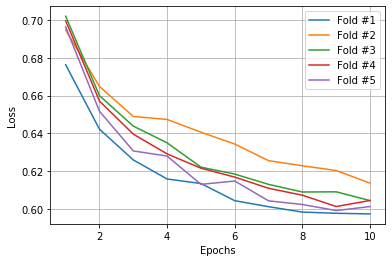

In [0]:
plot_loss_graph = plot_loss
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_loss_graph[i-1],label="Fold #{}".format(i))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("k-fold_loss.eps")
plt.savefig("k-fold_loss.png",dpi=150)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


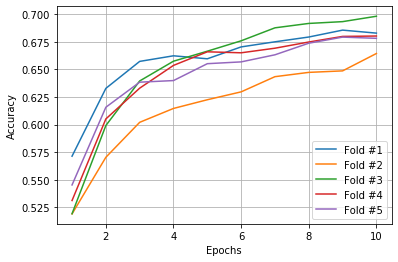

In [0]:
plt.clf()
plot_acc_graph = plot_acc
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_acc_graph[i-1],label="Fold #{}".format(i))

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("k-fold_acc.eps",dpi=150)
plt.savefig('k-fold_acc.png',dpi=150)
plt.show()

In [0]:
# Write the cross-validated prediction (from the last neural network)
X_holdout = np.expand_dims(x_holdout, axis=2)

holdout_pred = model.predict(X_holdout)
holdout_pred = np.argmax(holdout_pred, axis=1)
y_holdout_compare = np.argmax(y_holdout, axis=1)
score = metrics.accuracy_score(y_holdout_compare,holdout_pred)
print("Holdout score (accuracy): {}".format(score))



elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Holdout score (accuracy): 0.6996527777777778
Elapsed time: 0:00:55.37


In [0]:
# Write the cross-validated prediction (from the last neural network)

X_holdout = np.expand_dims(x_holdout, axis=2)
holdout_pred = model.predict(X_holdout)

score = metrics.log_loss(y_holdout, holdout_pred)
print("Log loss score: {}".format(score))

Log loss score: 0.5858364356595471


In [0]:
# Measure accuracy
holdout_pred = model.predict(X_holdout)
holdout_pred = np.argmax(holdout_pred, axis=1)
y_holdout_compare = np.argmax(y_holdout, axis=1)
score = metrics.accuracy_score(y_holdout_compare, holdout_pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.6996527777777778


## Output

In [0]:
history_dict = history.history

history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

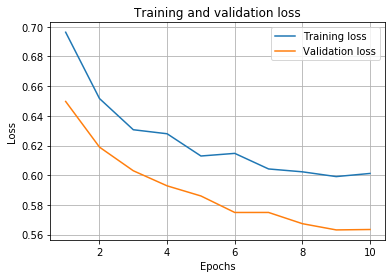

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss,  label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig('loss.png',dpi=150)
plt.show()


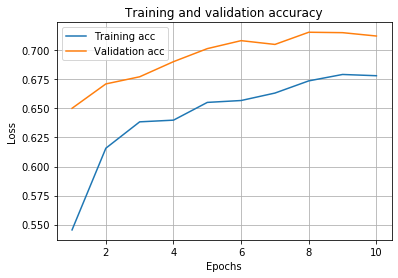

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc,  label='Training acc')
plt.plot(epochs, val_acc,  label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig('acc.png',dpi=150)
plt.show()

## Visualization Functions

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid()
    #plt.savefig('roc1.png',dpi=150)
    plt.show()   

### Confusion Matrix

Confusion matrix, without normalization
[[539 140]
 [260 443]]
Normalized confusion matrix
[[0.79 0.21]
 [0.37 0.63]]


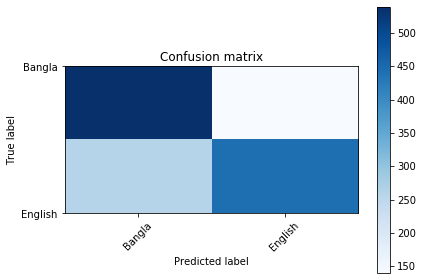

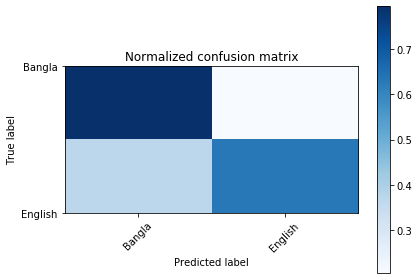

In [0]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_compare, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('cm.png',dpi=150)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, signal, title='Normalized confusion matrix')
plt.savefig('norm_cm.png',dpi=150)
plt.show()

In [0]:
[[TP,FN],[FP,TN]]=cm

Acc=(TP+TN)/(TP+TN+FP+FN)
print("Overall Accuracy: ",Acc*100)

Se=(TP)/(TP+FN)
print("Sensitivity: ",Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)

Overall Accuracy:  71.05643994211289
Sensitivity:  79.38144329896907
Specificity:  63.01564722617354
Error Rate:  28.94356005788712


### ROC Chart

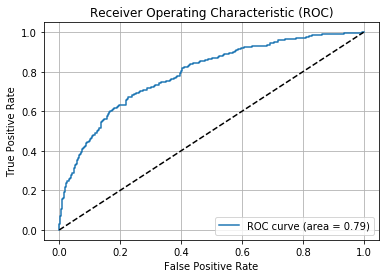

<Figure size 432x288 with 0 Axes>

In [0]:
pred = model.predict(X_test)
pred = pred[:,1] # Only positive cases
plot_roc(pred,y_compare)
plt.savefig('roc.png',dpi=150)

In [0]:
pred

array([0.38, 0.14, 0.22, ..., 0.32, 0.6 , 0.69], dtype=float32)

### Log-loss score

In [0]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = model.predict(X_test)

print("Numpy array of predictions")
print(pred[0]*100)

print("As percent probability")
display(pred[0:5])

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

Numpy array of predictions
[63.9822 38.0904]
As percent probability


array([[0.6398, 0.3809],
       [0.8168, 0.1359],
       [0.7818, 0.2171],
       [0.6215, 0.4239],
       [0.6511, 0.3904]], dtype=float32)

Log loss score: 0.5625036207180033


# Holdout Predictions

In [0]:
# Write the cross-validated prediction (from the last neural network)

X_holdout = np.expand_dims(x_holdout, axis=2)
holdout_pred = model.predict(X_holdout)

score = metrics.log_loss(y_holdout, holdout_pred)
print("Log loss score: {}".format(score))

Log loss score: 0.5858364356595471


In [0]:
# Measure accuracy
holdout_pred = model.predict(X_holdout)
holdout_pred = np.argmax(holdout_pred, axis=1)
y_holdout_compare = np.argmax(y_holdout, axis=1)
score = metrics.accuracy_score(y_holdout_compare, holdout_pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.6996527777777778


## Confusion Matrix

Confusion matrix, without normalization
[[690 197]
 [322 519]]
Normalized confusion matrix
[[0.78 0.22]
 [0.38 0.62]]


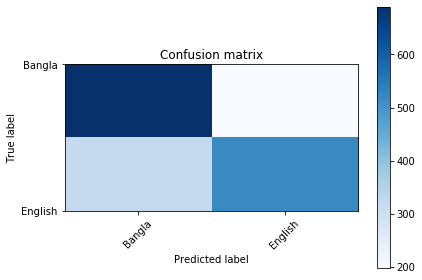

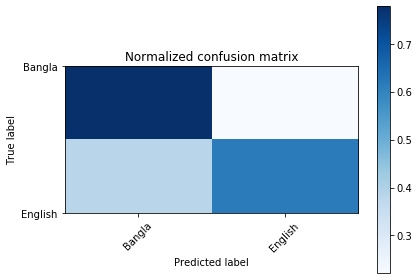

In [0]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare, holdout_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('cm2.png',dpi=150)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, signal, title='Normalized confusion matrix')
plt.savefig('norm_cm2.png',dpi=150)
plt.show()

In [0]:
print(confusion_matrix(y_holdout_compare, holdout_pred))  
print(classification_report(y_holdout_compare, holdout_pred))

[[690 197]
 [322 519]]
              precision    recall  f1-score   support

           0       0.68      0.78      0.73       887
           1       0.72      0.62      0.67       841

    accuracy                           0.70      1728
   macro avg       0.70      0.70      0.70      1728
weighted avg       0.70      0.70      0.70      1728



In [0]:
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)

Overall Accuracy:  69.96527777777779
Sensitivity:  77.7903043968433
Specificity:  61.71224732461356
Error Rate:  30.03472222222222


## ROC Chart

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

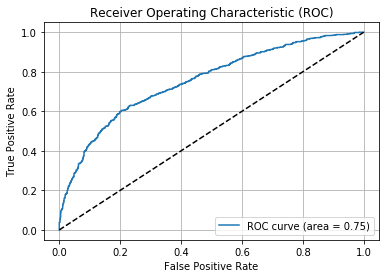

<Figure size 432x288 with 0 Axes>

In [0]:
holdout_pred = model.predict(X_holdout)
holdout_pred = holdout_pred[:,1] # Only positive cases
fig = plt.figure()
plt.figure()

plot_roc(holdout_pred, y_holdout_compare)
plt.savefig('roc2.png',dpi=150)
plt.show()

In [0]:
model.save('Bangla_English.h5')

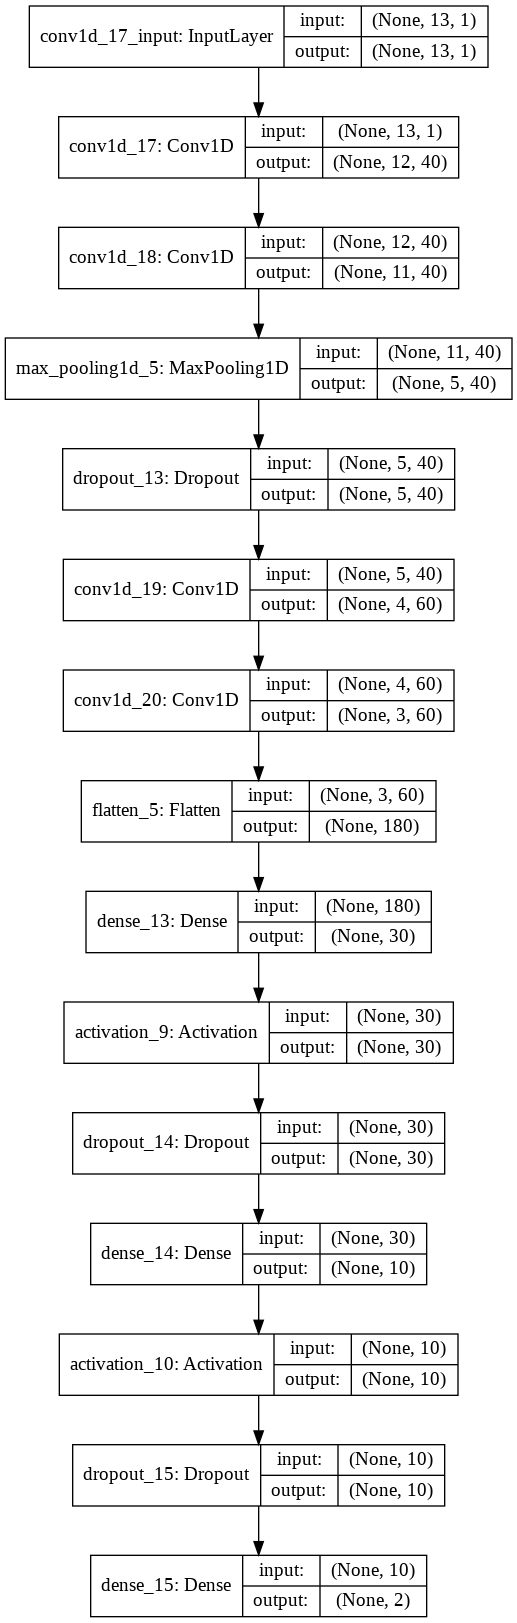

In [0]:
from keras.utils import plot_model
plot_model(model,show_shapes = True, to_file = 'model_10.png')

In [0]:
###### import model #####

import time
tic=time.time()
from keras.models import load_model
my_model=load_model('Bangla_English.h5')
toc=time.time()
print(str(1000*(toc-tic))+"ms")


OSError: ignored

In [0]:
## NOIZEUS CLEAN DATA AND RECORDED NOISY data testing .

import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

#path = "./data/"

#filename3 = os.path.join(path,"Clean_norm_test_250ms.csv")    
df3 = pd.read_csv('Bangla_test.csv',na_values=['NA','?'])

#filename4 = os.path.join(path,"Noisy_test_250ms.csv")    
df4 = pd.read_csv('English_test.csv',na_values=['NA','?'])
#frames = [df3, df4]
#df5 = pd.concat(frames, keys=['x', 'y'])

# Shuffle
np.random.seed(42)
df3 = df3.reindex(np.random.permutation(df3.index))
df3.reset_index(inplace=True, drop=True)

np.random.seed(42)
df4 = df4.reindex(np.random.permutation(df4.index))
df4.reset_index(inplace=True, drop=True)


#signal = encode_text_index(df5,"signal")
#x_holdout,y_holdout = to_xy(df5,"signal")



FileNotFoundError: ignored

In [0]:
#x_holdout = scaler.transform(x_holdout) 

In [0]:
df3

In [0]:
df4

In [0]:
Total_clean = df3.shape[0]
Total_noisy4 = df4.shape[0]

In [0]:
Total_clean

In [0]:
Total_noisy4

In [0]:

x_holdout_clean = df3
X_holdout_clean = np.expand_dims(x_holdout_clean, axis=2)

x_holdout_noisy4 = df4
X_holdout_noisy4 = np.expand_dims(x_holdout_noisy4, axis=2)




In [0]:
# Prediction for clean data

pred_clean = my_model.predict(X_holdout_clean)
pred_clean = np.argmax(pred_clean,axis=1)
clean_pred = 0
for i in range (0,Total_clean):
    if pred_clean[i] == 0: 
        clean_pred = clean_pred + 1   # clean =0 absence of noise
          
    


In [0]:
# Prediction for noisy data

pred_noisy4 = my_model.predict(X_holdout_noisy4)
pred_noisy4 = np.argmax(pred_noisy4,axis=1)
noisy_pred4 = 0
for i in range (0,Total_noisy4):
    if pred_noisy4[i] == 1: 
        noisy_pred4 = noisy_pred4 + 1   # noisy =1 presence of noise
          
    


In [0]:
#######For clean signal ######

Accuracy = clean_pred / (Total_clean)
print("Total_frames:",Total_clean)
print("Predicted:",clean_pred)
print("Noisy",Total_clean-clean_pred)
print("Accuracy:", Accuracy*100)
print("Acurracy for noisy", 100-(Accuracy*100))


In [0]:

#######For Noisy signal ######
Accuracy = noisy_pred4 / (Total_noisy4)
print("For (cleanspeech + 0.1(Noise))")
print("Total_frames:",Total_noisy4)
print("Predicted:",noisy_pred4)
print("Noisefre",Total_noisy4-noisy_pred4)
print("Accuracy:", Accuracy*100)
print("Acurracy for noisefree", 100-(Accuracy*100))
print("")


In [0]:
## NOIZEUS CLEAN DATA AND RECORDED NOISY data testing .

import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

path = "./data/"

filename3 = os.path.join(path,"FEMALE_testing_label.csv")    
df3 = pd.read_csv(filename3,na_values=['NA','?'])

filename4 = os.path.join(path,"0.1Fraction_label.csv")    
df4 = pd.read_csv(filename4,na_values=['NA','?'])
frames = [df3, df4]
df5 = pd.concat(frames, keys=['x', 'y'])

# Shuffle
np.random.seed(42)
df5 = df5.reindex(np.random.permutation(df5.index))
df5.reset_index(inplace=True, drop=True)


signal = encode_text_index(df5,"signal")
x_holdout01,y_holdout01 = to_xy(df5,"signal")






filename02 = os.path.join(path,"0.2Fraction_label.csv")    
df02 = pd.read_csv(filename02,na_values=['NA','?'])
frames = [df3, df02]
dfc02 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc02 = dfc02.reindex(np.random.permutation(dfc02.index))
dfc02.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc02,"signal")
x_holdout02,y_holdout02 = to_xy(dfc02,"signal")


filename03 = os.path.join(path,"0.3Fraction_label.csv")    
df03 = pd.read_csv(filename03,na_values=['NA','?'])
frames = [df3, df03]
dfc03 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc03 = dfc03.reindex(np.random.permutation(dfc03.index))
dfc03.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc03,"signal")
x_holdout03,y_holdout03 = to_xy(dfc03,"signal")




filename04 = os.path.join(path,"0.4Fraction_label.csv")    
df04 = pd.read_csv(filename04,na_values=['NA','?'])
frames = [df3, df04]
dfc04 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc04 = dfc04.reindex(np.random.permutation(dfc04.index))
dfc04.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc04,"signal")
x_holdout04,y_holdout04 = to_xy(dfc04,"signal")




filename05 = os.path.join(path,"0.5Fraction_label.csv")    
df05 = pd.read_csv(filename05,na_values=['NA','?'])
frames = [df3, df05]
dfc05 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc05 = dfc05.reindex(np.random.permutation(dfc05.index))
dfc05.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc05,"signal")
x_holdout05,y_holdout05 = to_xy(dfc05,"signal")







In [0]:
# Write the cross-validated prediction (from the last neural network)

X_holdout01 = np.expand_dims(x_holdout01, axis=2)
holdout_pred01 = my_model.predict(X_holdout01)
score = metrics.log_loss(y_holdout01, holdout_pred01)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred01 = np.argmax(holdout_pred01, axis=1)
y_holdout_compare01 = np.argmax(y_holdout01, axis=1)
score = metrics.accuracy_score(y_holdout_compare01, holdout_pred01)
print("Final accuracy: {}".format(score))




# Write the cross-validated prediction (from the last neural network)

X_holdout02 = np.expand_dims(x_holdout02, axis=2)
holdout_pred02 = my_model.predict(X_holdout02)
score = metrics.log_loss(y_holdout02, holdout_pred02)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred02 = np.argmax(holdout_pred02, axis=1)
y_holdout_compare02 = np.argmax(y_holdout02, axis=1)
score = metrics.accuracy_score(y_holdout_compare02, holdout_pred02)
print("Final accuracy: {}".format(score))


# Write the cross-validated prediction (from the last neural network)

X_holdout03 = np.expand_dims(x_holdout03, axis=2)
holdout_pred03 = my_model.predict(X_holdout03)
score = metrics.log_loss(y_holdout03, holdout_pred03)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred03 = np.argmax(holdout_pred03, axis=1)
y_holdout_compare03 = np.argmax(y_holdout03, axis=1)
score = metrics.accuracy_score(y_holdout_compare03, holdout_pred03)
print("Final accuracy: {}".format(score))





# Write the cross-validated prediction (from the last neural network)

X_holdout04 = np.expand_dims(x_holdout04, axis=2)
holdout_pred04 = my_model.predict(X_holdout04)
score = metrics.log_loss(y_holdout04, holdout_pred04)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred04 = np.argmax(holdout_pred04, axis=1)
y_holdout_compare04 = np.argmax(y_holdout04, axis=1)
score = metrics.accuracy_score(y_holdout_compare04, holdout_pred04)
print("Final accuracy: {}".format(score))



# Write the cross-validated prediction (from the last neural network)

X_holdout05 = np.expand_dims(x_holdout05, axis=2)
holdout_pred05 = my_model.predict(X_holdout05)
score = metrics.log_loss(y_holdout05, holdout_pred05)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred05 = np.argmax(holdout_pred05, axis=1)
y_holdout_compare05 = np.argmax(y_holdout05, axis=1)
score = metrics.accuracy_score(y_holdout_compare05, holdout_pred05)
print("Final accuracy: {}".format(score))





In [0]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare01, holdout_pred01)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.1Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')


# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare02, holdout_pred02)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.2Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')






# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare03, holdout_pred03)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.3Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')









In [0]:
# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare04, holdout_pred04)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.4Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')





# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare05, holdout_pred05)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.5Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')



In [0]:
filename06 = os.path.join(path,"0.6Fraction_label.csv")    
df06 = pd.read_csv(filename06,na_values=['NA','?'])
frames = [df3, df06]
dfc06 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc06 = dfc06.reindex(np.random.permutation(dfc06.index))
dfc06.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc06,"signal")
x_holdout06,y_holdout06 = to_xy(dfc06,"signal")





filename07 = os.path.join(path,"0.7Fraction_label.csv")    
df07 = pd.read_csv(filename07,na_values=['NA','?'])
frames = [df3, df07]
dfc07 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc07 = dfc07.reindex(np.random.permutation(dfc07.index))
dfc07.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc07,"signal")
x_holdout07,y_holdout07 = to_xy(dfc07,"signal")





filename08 = os.path.join(path,"0.8Fraction_label.csv")    
df08 = pd.read_csv(filename08,na_values=['NA','?'])
frames = [df3, df08]
dfc08 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc08 = dfc08.reindex(np.random.permutation(dfc08.index))
dfc08.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc08,"signal")
x_holdout08,y_holdout08 = to_xy(dfc08,"signal")






filename09 = os.path.join(path,"0.9Fraction_label.csv")    
df09 = pd.read_csv(filename09,na_values=['NA','?'])
frames = [df3, df09]
dfc09 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc09 = dfc09.reindex(np.random.permutation(dfc09.index))
dfc09.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc09,"signal")
x_holdout09,y_holdout09 = to_xy(dfc09,"signal")




filename11 = os.path.join(path,"1Fraction_label.csv")    
df11 = pd.read_csv(filename11,na_values=['NA','?'])
frames = [df3, df11]
dfc011 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc011 = dfc011.reindex(np.random.permutation(dfc011.index))
dfc011.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc011,"signal")
x_holdout11,y_holdout11 = to_xy(dfc011,"signal")

In [0]:
# Write the cross-validated prediction (from the last neural network)

X_holdout06 = np.expand_dims(x_holdout06, axis=2)
holdout_pred06 = my_model.predict(X_holdout06)
score = metrics.log_loss(y_holdout06, holdout_pred06)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred06 = np.argmax(holdout_pred06, axis=1)
y_holdout_compare06 = np.argmax(y_holdout06, axis=1)
score = metrics.accuracy_score(y_holdout_compare06, holdout_pred06)
print("Final accuracy: {}".format(score))


# Write the cross-validated prediction (from the last neural network)

X_holdout07 = np.expand_dims(x_holdout07, axis=2)
holdout_pred07 = my_model.predict(X_holdout07)
score = metrics.log_loss(y_holdout07, holdout_pred07)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred07 = np.argmax(holdout_pred07, axis=1)
y_holdout_compare07 = np.argmax(y_holdout07, axis=1)
score = metrics.accuracy_score(y_holdout_compare07, holdout_pred07)
print("Final accuracy: {}".format(score))


# Write the cross-validated prediction (from the last neural network)

X_holdout08 = np.expand_dims(x_holdout08, axis=2)
holdout_pred08 = my_model.predict(X_holdout08)
score = metrics.log_loss(y_holdout08, holdout_pred08)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred08 = np.argmax(holdout_pred08, axis=1)
y_holdout_compare08 = np.argmax(y_holdout08, axis=1)
score = metrics.accuracy_score(y_holdout_compare08, holdout_pred08)
print("Final accuracy: {}".format(score))


# Write the cross-validated prediction (from the last neural network)

X_holdout09 = np.expand_dims(x_holdout09, axis=2)
holdout_pred09 = my_model.predict(X_holdout09)
score = metrics.log_loss(y_holdout09, holdout_pred09)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred09 = np.argmax(holdout_pred09, axis=1)
y_holdout_compare09 = np.argmax(y_holdout09, axis=1)
score = metrics.accuracy_score(y_holdout_compare09, holdout_pred09)
print("Final accuracy: {}".format(score))

# Write the cross-validated prediction (from the last neural network)

X_holdout11 = np.expand_dims(x_holdout11, axis=2)
holdout_pred11 = my_model.predict(X_holdout11)
score = metrics.log_loss(y_holdout11, holdout_pred11)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred11 = np.argmax(holdout_pred11, axis=1)
y_holdout_compare11 = np.argmax(y_holdout11, axis=1)
score = metrics.accuracy_score(y_holdout_compare11, holdout_pred11)
print("Final accuracy: {}".format(score))

In [0]:
# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare06, holdout_pred06)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.6Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')


# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare07, holdout_pred07)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.7Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')




In [0]:

# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare08, holdout_pred08)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.8Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')


# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare09, holdout_pred09)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.9Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')


# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare11, holdout_pred11)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('1Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')



In [0]:


filename001 = os.path.join(path,"0.001Fraction_label.csv")    
df001= pd.read_csv(filename001,na_values=['NA','?'])
frames = [df3, df001]
dfc001 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc001 = dfc001.reindex(np.random.permutation(dfc001.index))
dfc001.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc001,"signal")
x_holdout001,y_holdout001 = to_xy(dfc001,"signal")


filename005 = os.path.join(path,"0.005Fraction_label.csv")    
df005 = pd.read_csv(filename005,na_values=['NA','?'])
frames = [df3, df005]
dfc005 = pd.concat(frames, keys=['x', 'y'])
#shuffle
np.random.seed(42)
dfc005 = dfc005.reindex(np.random.permutation(dfc005.index))
dfc005.reset_index(inplace=True, drop=True)
signal = encode_text_index(dfc005,"signal")
x_holdout005,y_holdout005 = to_xy(dfc005,"signal")

# Write the cross-validated prediction (from the last neural network)

X_holdout001 = np.expand_dims(x_holdout001, axis=2)
holdout_pred001 = my_model.predict(X_holdout001)
score = metrics.log_loss(y_holdout001, holdout_pred001)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred001 = np.argmax(holdout_pred001, axis=1)
y_holdout_compare001 = np.argmax(y_holdout001, axis=1)
score = metrics.accuracy_score(y_holdout_compare001, holdout_pred001)
print("Final accuracy: {}".format(score))


# Write the cross-validated prediction (from the last neural network)

X_holdout005 = np.expand_dims(x_holdout005, axis=2)
holdout_pred005 = my_model.predict(X_holdout005)
score = metrics.log_loss(y_holdout005, holdout_pred005)
print("Log loss score: {}".format(score))

# Measure accuracy
holdout_pred005 = np.argmax(holdout_pred005, axis=1)
y_holdout_compare005 = np.argmax(y_holdout005, axis=1)
score = metrics.accuracy_score(y_holdout_compare005, holdout_pred005)
print("Final accuracy: {}".format(score))

In [0]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare001, holdout_pred001)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.01Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')


# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare005, holdout_pred005)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, signal)
plt.savefig('0.05Fraction.png',dpi=150)
print('')
[[TP,FN],[FP,TN]]=cm

Acc=((TP+TN)/(TP+TN+FP+FN)) * 100
print("Overall Accuracy: ", Acc)

Se=(TP)/(TP+FN)
print("Sensitivity: ", Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=(FP+FN)/(TP+TN+FP+FN)
print("Error Rate: ",ER*100)
print('')
print('')


In [0]:
my_model.summary()
